In [5]:
import sys
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib
import toml
import time
from ipywidgets import *
import cv2
import uuid
from absl import logging
logging.set_verbosity(0)

import copy
import os
import json

from datetime import datetime

In [6]:
import sys
sys.path.append("/home/anujraaj/mule")

In [7]:
from src.lc_utils import load_imu_data
from src.submap import Submap
from src.lc_utils import combine_yelli_poses, get_inverse_yelli_pose, imu_pose_estimate, normalize_pose

In [8]:
from ati.perception.lidar import lidar_pb, lidar_utils
from ati.perception.lidar.lidar_voxel import voxel_filter
from ati.perception.utils.voxel_filter_utils import voxel_filter_fast
from ati.perception.lidar.lidar_frame import *
from ati.slam.yelli import utils, grid
from utils.imu_tracker import ImuTracker

data [0.3 0.4 0.5 1.  0.5 0.5 0.3 0.7 0.  0.9 0.9 0.5 0.2 0.1 0.7]
unique [0.  0.1 0.2 0.3 0.4 0.5 0.7 0.9 1. ]
sorted [0.  0.1 0.2 0.3 0.3 0.4 0.5 0.5 0.5 0.5 0.7 0.7 0.9 0.9 1. ]
indices of unique values [ 0  1  2  3  5  6 10 12 14]
argsort [ 8 13 12  0  6  1  2  4  5 11  7 14  9 10  3]


## Submap Generation

In [9]:
max_frames = 32000 
# data_dir = "/atidata/demo/SLLumax/2021-07/21-07-2021/map_raw_data/2021-07-21-10-50-46-mini20-02-manual-sllmax_map/"
data_dir =r"/atidata/customer/Bosch/2021-08-30-16-24-40-minimule-11-3-manual-Bosch-32beam_capture_2"
data_dir=r"/Users/anujraaj/robotics/SLAM-loop-closure/data/indoor-run/2021-12-29-11-52-57-minimule-11-2-manual-bosch_nashik_indoor"
data_dir=r"/Users/anujraaj/robotics/SLAM-loop-closure/data/2021-11-11-15-31-42-minimule-11-2-manual-floor_1__mapping"
data_dir=r"/atidata/customer/Flipkart_Malur_Impl/floor-Gplus1-repeat-32beams/2021-11-11-15-31-42-minimule-11-2-manual-floor_1__mapping/"
data_dir = "/atidata/customer/Flipkart_Malur_Impl/floor-Gplus1-repeat-32beams/2021-11-11-15-31-42-minimule-11-2-manual-floor_1__mapping/"


In [10]:
bootstrap_frames =20

grid_res = 0.05 
grid_alpha =1
num_submap_range_data = 90
alpha= 1.05
start_frame = 50

grid_params = {
    "x": (-0.1, 0.1),
#    "x": (-0.2, 0.2),
#    "x": (-0.4, 0.4),
#    "y": (-0.02, 0.30),
    "y": (-0.20, 0.30),
#    "y": (-0.40, 0.60),
    "theta": (-0.2, 0.2),
#    "num_x": 11,
#    "num_x": 22,
#    "num_x": 44,
#    "num_y": 17,
#    "num_y" : 26,
#    "num_y" : 52,
#    "num_t": 41,
    "num_t": 61,
    
}

grid_params['num_x'] = int((grid_params['x'][1] - grid_params['x'][0])/grid_res + 1)
grid_params['num_y'] = int((grid_params['y'][1] - grid_params['y'][0])/grid_res + 1)



zmin, zmax = 0.3, 2.0

In [11]:
z_slices = [(zmin,zmax)]
print("Using Z slices:", z_slices)

Using Z slices: [(0.3, 2.0)]


In [12]:
imu_data = load_imu_data(data_dir)
imu_tracker = ImuTracker()
imu_bias_initialized = False
i = 0
while not imu_bias_initialized:
    imu_bias_initialized = imu_tracker.get_initial_gyro_bias(imu_data.iloc[i])
    i += 1


In [13]:
pose = np.array([0.,0., np.pi/2])
prev_pose = pose.copy()
spose = pose #local submap pose

In [14]:
submaps, active_submaps, finished_submaps = [], [], [] #active_submaps contain two two at a time -- implementation for overlapping submaps
best_scores = []
node_poses = [] #? poses of inserted frames in the global frame
inserted_frame_ids=[] #frame_id for inserted frame
submap = Submap(spose.copy(), grid_res, grid_alpha)
active_submaps.append(submap)

In [11]:
count_once = True

In [12]:
try:
    lpb = lidar_pb.LidarSmallPb(data_dir)
except:
    lpb = lidar_pb.LidarPb(data_dir)
prev_frame_time, prev_frame = lpb.get_frame(start_frame - 2)
num_frames = np.minimum(len(lpb.list_frames()), max_frames)
print(f"total frames {num_frames}")
for frame_id in range(start_frame, num_frames - 1):
    #if frame_id % 2 != 0:
        #continue
    try:
        frame_time, frame = lpb.get_frame(frame_id)
    except:
        print(f"skipping {frame_id}. divide-by-zero error")
        continue

    frame = np.copy(frame[:, :6]).astype(np.float64)
    frame = frame[(frame[:,4]>0) & (frame[:,4] < 60)]
    frame = frame[(frame[:,2] > zmin) & (frame[:,2] < zmax)]
    #filtered_frame = voxel_filter(frame, voxel_size=0.05)
    filtered_frame,_ = voxel_filter_fast(voxel_filter(frame, voxel_size=0.05), trunc=False, voxel = 0.25)
    frame_z = voxel_filter(frame[:,:3], voxel_size=0.05)
    
    if frame_id < start_frame + bootstrap_frames:
        print("Num Bootstrap insertions", active_submaps[0].num_insertions)
        spose = combine_yelli_poses(pose, get_inverse_yelli_pose(active_submaps[0].pose)) # pose wrt submap origin
        node_poses.append(pose)
        inserted_frame_ids.append(frame_id)
        active_submaps[0].insert_points(frame_z, spose, frame_id, node_id = len(node_poses)-1 )
#         frame_list.append(frame_id)
#         poses.append(pose)
        prev_insert_ts = frame_time
        prev_frame_time, prev_frame = frame_time, frame
        last_inserted_pose = pose.copy()
        continue
    
    #HACK
    #skip if vehicle is not moving. Skip?
    
    relevant_imu_data = imu_data[imu_data["time"].between(prev_frame_time, frame_time)]
    for imu_idx in range(relevant_imu_data.shape[0]):
        imu_tracker.add_imu_data(relevant_imu_data.iloc[imu_idx])
    
    pose_estimate = imu_pose_estimate(imu_tracker, frame_time, pose) #only theta around which we need to search changes
    spose_estimate = combine_yelli_poses(get_inverse_yelli_pose(active_submaps[0].pose),pose_estimate)
    search_space = utils.grid_space(center=spose_estimate, **grid_params)
    
    if count_once is True:
        scores,n_unique_visited_points = active_submaps[0].search(filtered_frame, search_space, count_once = True)
        scores = scores/n_unique_visited_points
    else:
        scores = active_submaps[0].search(filtered_frame, search_space, count_once = False)
    
    best = np.argmax(scores)
    best_scores.append(scores[best])
    
    spose = search_space[best]
    pose = combine_yelli_poses(active_submaps[0].pose, spose)
    
    #HACK
    if len(frame_z) < 500:
        continue
    #Check all quadrants have points
    if (np.sum((frame_z[:,0] < 0) & (frame_z[:,1] > 0)) <10) or \
    (np.sum((frame_z[:,0] < 0) & (frame_z[:,1] < 0)) <10) or \
    (np.sum((frame_z[:,0] > 0) & (frame_z[:,1] > 0)) <10) or \
    (np.sum((frame_z[:,0] > 0) & (frame_z[:,1] < 0)) <10):
        continue
    
    if (np.linalg.norm(pose[:2]-last_inserted_pose[:2])> 0.15 or (prev_insert_ts - frame_time)>1) :
        node_poses.append(pose)
        inserted_frame_ids.append(frame_id)
        active_submaps[0].insert_points(frame_z, spose, frame_id, node_id=len(node_poses)-1)
        if len(active_submaps) ==1:
        
            if active_submaps[0].num_insertions >= int(num_submap_range_data/2):
                active_submaps.append(Submap(pose.copy(), grid_res, grid_alpha))
                s2pose = combine_yelli_poses(get_inverse_yelli_pose(active_submaps[1].pose),pose)
                active_submaps[1].insert_points(frame_z,s2pose, frame_id, node_id=len(node_poses)-1)
                #print(f"spose {spose}, s2pose {s2pose}")
                
        else:
            
            s2pose = combine_yelli_poses(get_inverse_yelli_pose(active_submaps[1].pose),pose)
            active_submaps[1].insert_points(frame_z,s2pose, frame_id, node_id=len(node_poses)-1)
            #print(f"len else spose {spose}, s2pose {s2pose}")
            
        if active_submaps[0].num_insertions >= num_submap_range_data - 1:
            active_submaps[0].finish()
            finished_submaps.append(active_submaps.pop(0))
            active_submaps.append(Submap(pose.copy(), grid_res, grid_alpha))
            s2pose = combine_yelli_poses(get_inverse_yelli_pose(active_submaps[1].pose), pose)
            active_submaps[1].insert_points(frame_z,s2pose, frame_id, node_id=len(node_poses)-1)
        
        #print("num active submaps", len(active_submaps))
        prev_insert_ts = frame_time
        last_inserted_pose = pose.copy()
    if frame_id % 250 == 0:
        print(f"frame:{frame_id} scores:{best_scores[-1]} best pose:{pose}  ")
    prev_frame_time, prev_frame = frame_time, frame
node_poses = np.array(node_poses)
inserted_frame_ids = np.array(inserted_frame_ids)
# print(f"final pose {poses[-1]}")
    

total frames 27638
Num Bootstrap insertions 0
Num Bootstrap insertions 1
Num Bootstrap insertions 2
Num Bootstrap insertions 3
Num Bootstrap insertions 4
Num Bootstrap insertions 5
Num Bootstrap insertions 6
Num Bootstrap insertions 7
Num Bootstrap insertions 8
Num Bootstrap insertions 9
Num Bootstrap insertions 10
Num Bootstrap insertions 11
Num Bootstrap insertions 12
Num Bootstrap insertions 13
Num Bootstrap insertions 14
Num Bootstrap insertions 15
Num Bootstrap insertions 16
Num Bootstrap insertions 17
Num Bootstrap insertions 18
Num Bootstrap insertions 19
frame:250 scores:0.788163358554579 best pose:[0.         0.         1.57082695]  
frame:500 scores:0.7849897318652183 best pose:[0.        0.        1.5711034]  
frame:750 scores:0.7781111293589882 best pose:[0.         0.         1.57110896]  
frame:1000 scores:0.7847013314694867 best pose:[0.         0.         1.57120154]  
frame:1250 scores:0.7172158868537609 best pose:[ 0.31501047 15.94082645  1.65829522]  
frame:1500 scor

frame:21500 scores:0.5425153318674731 best pose:[ 53.85488167 123.24689097  -1.60530539]  
frame:21750 scores:0.69365064612321 best pose:[ 52.85619768 104.53163374  -1.62017917]  
frame:22000 scores:0.7018812513930078 best pose:[52.61864601 85.64037797 -1.50755722]  
frame:22250 scores:0.775217058365646 best pose:[52.24298609 66.79425186 -1.57791233]  
frame:22500 scores:0.6159125440449069 best pose:[51.62219484 47.94737777 -1.51362331]  
frame:22750 scores:0.7579196273608196 best pose:[50.71696646 29.1606479  -1.58777359]  
frame:23000 scores:0.7693279762548859 best pose:[51.01035993 10.36779125 -1.53003734]  
frame:23250 scores:0.7512921328120509 best pose:[50.54991549 -0.93199199 -1.53860525]  
frame:23500 scores:0.5344877769899848 best pose:[38.12558299 -2.60204384  3.13106897]  
frame:23750 scores:0.7297531503421824 best pose:[23.10483637  0.72063149  1.60595203]  
frame:24000 scores:0.7347041587634306 best pose:[23.76669187 20.01171783  1.61993805]  
frame:24250 scores:0.77465040

### Saving and Plotting generated Submaps

In [57]:
# node_poses

In [26]:
import pickle

with open("maps/5/submaps-node_poses-inserted_frame_ids_countonce.pickle", 'wb') as f:
    pickle.dump((finished_submaps, node_poses, inserted_frame_ids),f)

In [15]:
# with open("maps/2/submaps-node_poses-inserted_frame_ids.pkl", 'rb') as f:
#     random = pickle.load(f)

<IPython.core.display.Javascript object>


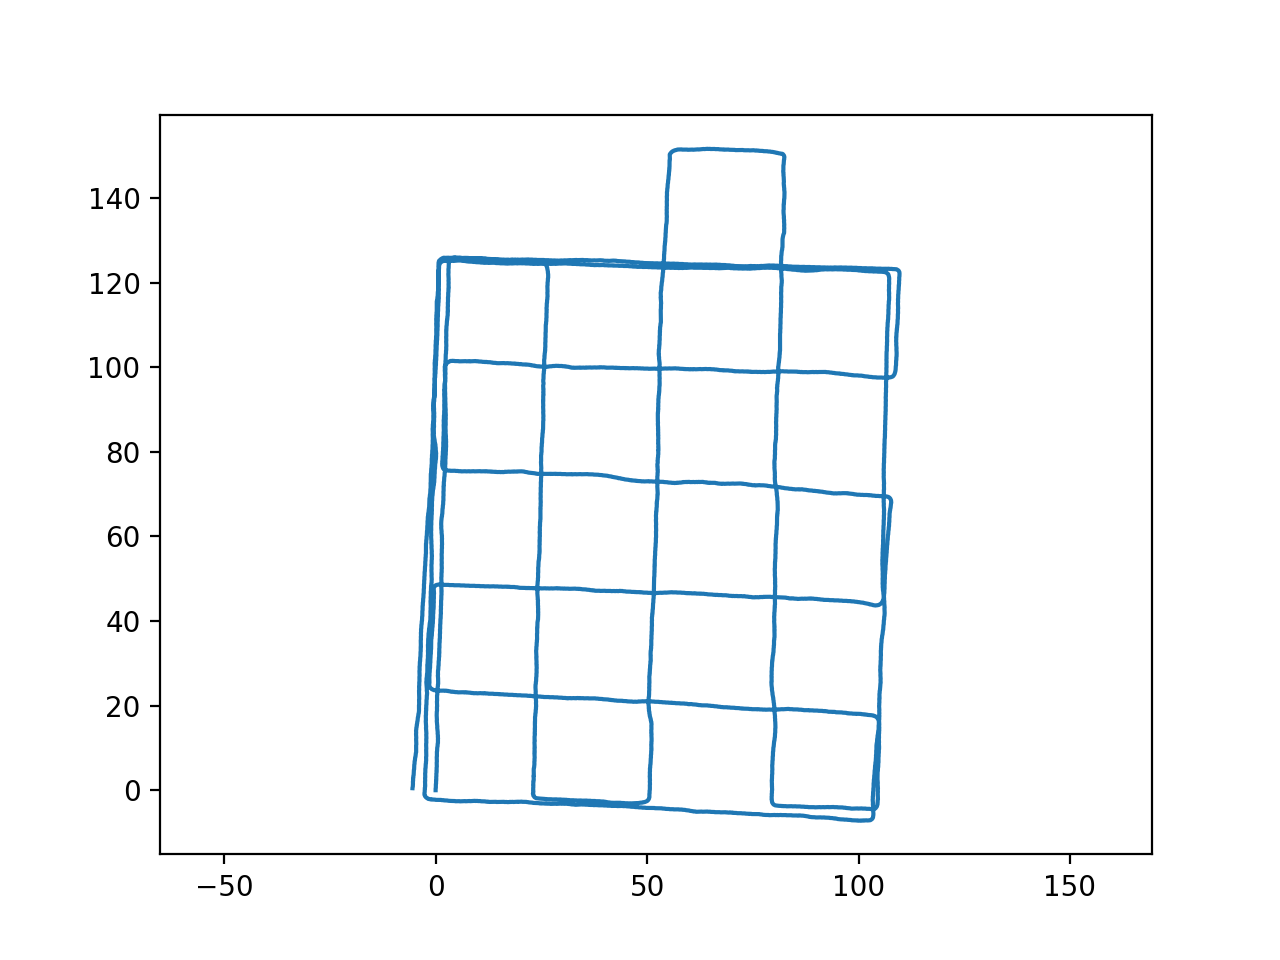

(-11.225767128892368,
 115.45215801249205,
 -15.179834279163876,
 159.60958386537877)

In [84]:
node_poses = np.array(node_poses)
st = 0; stp = -1
plt.figure()
plt.plot(node_poses[st:stp,0], node_poses[st:stp,1], )
plt.axis('equal')


In [58]:
# node_poses

<IPython.core.display.Javascript object>


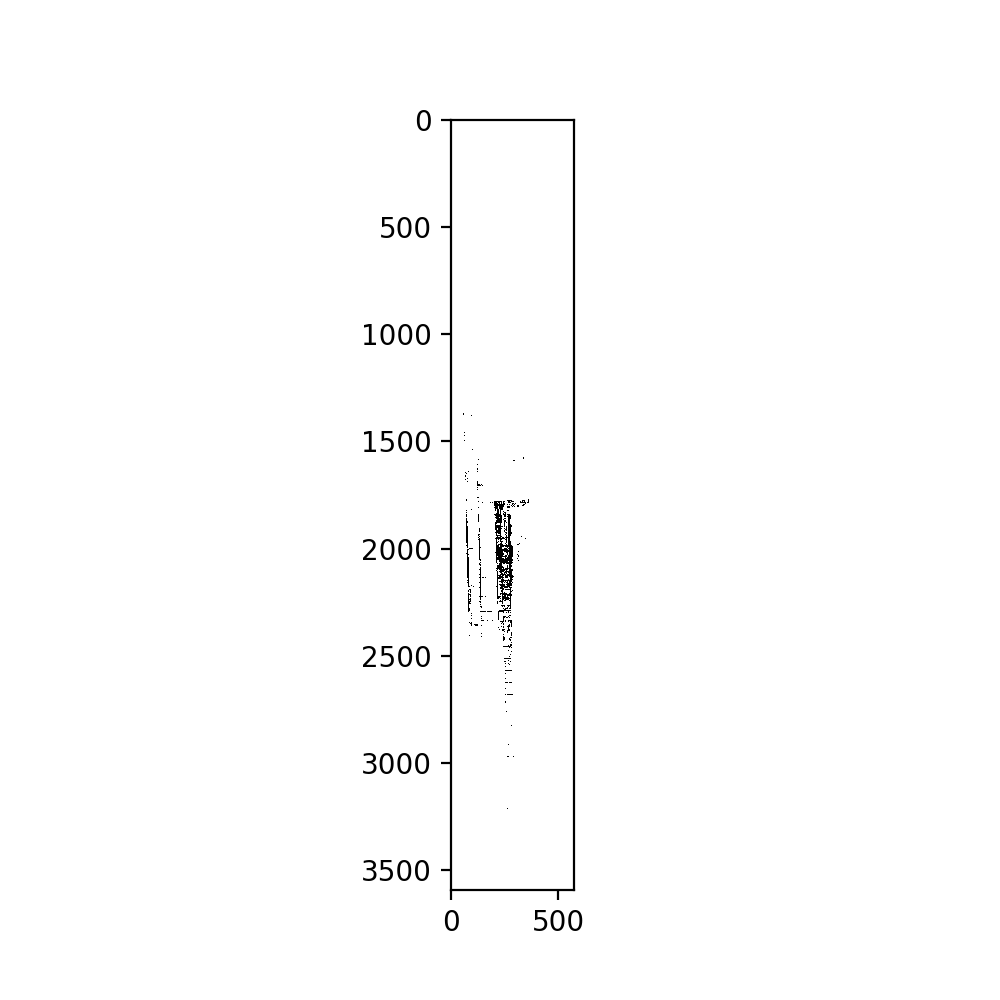

(574, 3594)


In [87]:
# %matplotlib inline
%matplotlib notebook
# %matplotlib notebook
plt.figure(figsize = (5,5))
#plt.imshow(1-(finished_submaps[2].grid.grid.T> 0), cmap='gray') 
idx = 0
if finished_submaps[idx].iscompressed:
        finished_submaps[idx].decompress_data()
plt.imshow(1 - (finished_submaps[idx].grid.grid.T>0), cmap='gray') 
print(finished_submaps[idx].grid.grid.shape)
#print(np.sum(finished_submaps[1].grid.grid >0))

In [60]:
print( len(finished_submaps), len(node_poses), len(inserted_frame_ids))

204 9064 9064


# Finding Constraints

In [20]:
import branch_bound as bb
from importlib import reload
from constraint import Constraint
import pg

reload(bb)
reload(pg)

<module 'pg' from '/home/anujraaj/robo/SLAM-loop-closure/pg.py'>

### Version-1: Find constraints altogether at the end.

In [50]:
x_search_window = (-2,2)
y_search_window = (-2,2)
angle_search_window = (-np.pi/6, np.pi/6)
score_th=0.8
dist_th = 5
node_dists = np.cumsum(np.linalg.norm(node_poses[1:,:2]-node_poses[:-1,:2], axis = 1))
node_dists = np.concatenate(([0],node_dists))
print(len(node_dists), len(node_poses))

9064 9064


In [51]:
constraints=[]
for sid in range(len(finished_submaps)):
    submap = finished_submaps[sid]
    if submap.iscompressed:
        submap.decompress_data()
    hgrids =  bb.compute_hierarchical_grid(submap.grid, num_levels=4)
    for nid in range(len(node_poses)):
        npose = node_poses[nid]
        dist = np.linalg.norm(npose[:2] - submap.pose[:2])
        node_dist = abs(node_dists[nid] - node_dists[submap.node_ids[0]])
        if node_dist < 20:
            continue
        if nid not in submap.node_ids and (dist < dist_th):
            fr_id = inserted_frame_ids[nid]
            ts, frame = lpb.get_frame(fr_id)
            frame = np.copy(frame[:, :6]).astype(np.float64)
            frame = frame[(frame[:,4]>0) & (frame[:,4] < 60)]
            frame = frame[(frame[:,2] > zmin) & (frame[:,2] < zmax)]
            frame_z = voxel_filter(frame[:,:3], voxel_size=0.05)
            if len(frame_z) < 500:
                continue
            #Check all quadrants have points
            if (np.sum((frame_z[:,0] < 0) & (frame_z[:,1] > 0)) <10) or \
            (np.sum((frame_z[:,0] < 0) & (frame_z[:,1] < 0)) <10) or \
            (np.sum((frame_z[:,0] > 0) & (frame_z[:,1] > 0)) <10) or \
            (np.sum((frame_z[:,0] > 0) & (frame_z[:,1] < 0)) <10):
                continue
            frame_z,_ = voxel_filter_fast(frame_z, trunc=False, voxel = 0.25)  
            
            spose_estimate = combine_yelli_poses(get_inverse_yelli_pose(submap.pose), npose)
            hpose, hscore = bb.hierarchical_search(hgrids, spose_estimate, frame_z,
                                        x_search_window,y_search_window,angle_search_window
                                        ,count_once=True, max_range = 60, score_th = score_th, debug=False)
            if hpose is not None:    
                print("sid, nids, pose, score: ",[submap.node_ids[0], nid], hpose, hscore)
                constraints.append(Constraint([submap.node_ids[0], nid], hpose))
    print(f"Submap {sid} done..")
    submap.compress_data()

sid, nids, pose, score:  [0, 4244] [0.11675523 1.88263737 1.57570846] 0.8003867224616429
Submap 0 done..
Submap 1 done..
Submap 2 done..
sid, nids, pose, score:  [132, 4366] [-0.13370811  3.51458869  1.53921433] 0.8420666615287044
Submap 3 done..
sid, nids, pose, score:  [176, 3020] [ 0.14752503  3.94444127 -1.6074135 ] 0.8249418794774028
Submap 4 done..
sid, nids, pose, score:  [220, 2975] [-0.00544996  4.32302664 -1.48760225] 0.8302904402044937
sid, nids, pose, score:  [220, 2976] [ 0.00743633  4.10238027 -1.50465106] 0.8116781840866157
sid, nids, pose, score:  [220, 2977] [ 0.02288849  4.00692948 -1.53121291] 0.8092506091932996
sid, nids, pose, score:  [220, 2978] [ 0.03121738  3.72336649 -1.55637098] 0.8213658641827961
Submap 5 done..
Submap 6 done..
Submap 7 done..
Submap 8 done..
sid, nids, pose, score:  [396, 1786] [ 0.04918543  6.51738355 -1.52092724] 0.8288240503311017
sid, nids, pose, score:  [396, 4631] [-0.425526    2.54973991  1.66513321] 0.804923255630837
Submap 9 done..


sid, nids, pose, score:  [1188, 5420] [0.17795226 2.57960564 1.60189552] 0.8334381453122937
sid, nids, pose, score:  [1188, 5421] [0.16814708 2.83644789 1.60263923] 0.8229485800248194
sid, nids, pose, score:  [1188, 5422] [0.1695352  3.02172771 1.60634683] 0.8497685175093412
sid, nids, pose, score:  [1188, 5423] [0.15934042 3.2769838  1.60386139] 0.830787673505
sid, nids, pose, score:  [1188, 5424] [0.20479195 3.46821092 1.60549671] 0.847547942182071
sid, nids, pose, score:  [1188, 5425] [0.18725333 3.67405099 1.60485571] 0.8345853451526285
sid, nids, pose, score:  [1188, 5426] [0.18099366 3.87484967 1.60192129] 0.8312018834389227
Submap 27 done..
Submap 28 done..
Submap 29 done..
Submap 30 done..
Submap 31 done..
Submap 32 done..
Submap 33 done..
Submap 34 done..
Submap 35 done..
Submap 36 done..
Submap 37 done..
Submap 38 done..
sid, nids, pose, score:  [1716, 8607] [-0.52823312  2.21549152  1.8048449 ] 0.8253968819657068
sid, nids, pose, score:  [1716, 8609] [-0.62221769  2.67064542

sid, nids, pose, score:  [2948, 244] [-0.53401169  4.0394981   0.03824114] 0.8269515021327645
Submap 67 done..
sid, nids, pose, score:  [2992, 205] [-0.11393328  3.65449034 -1.55195467] 0.8111621086104355
sid, nids, pose, score:  [2992, 4423] [-0.09563981  3.22642185 -1.59935789] 0.8343758362000072
sid, nids, pose, score:  [2992, 4425] [-0.17015413  2.82040973 -1.60376925] 0.8551617945480989
sid, nids, pose, score:  [2992, 4428] [-0.17485059  2.1033511  -1.56985786] 0.8065209118709429
sid, nids, pose, score:  [2992, 4430] [-0.23580913  1.77555325 -1.50318922] 0.8307993895630086
sid, nids, pose, score:  [2992, 8866] [0.25319153 2.27734754 1.62789572] 0.8092651654322799
Submap 68 done..
Submap 69 done..
Submap 70 done..
Submap 71 done..
Submap 72 done..
Submap 73 done..
Submap 74 done..
Submap 75 done..
Submap 76 done..
Submap 77 done..
Submap 78 done..
Submap 79 done..
Submap 80 done..
Submap 81 done..
sid, nids, pose, score:  [3608, 5835] [0.86462559 7.31558969 1.5773943 ] 0.8582752375

sid, nids, pose, score:  [4532, 331] [0.41510638 3.3262577  1.49518321] 0.8574095283067351
sid, nids, pose, score:  [4532, 8755] [ 0.40303302  2.1089437  -1.66530171] 0.8171855275557572
Submap 103 done..
Submap 104 done..
sid, nids, pose, score:  [4620, 401] [ 0.17601456 -0.22871076  1.43673704] 0.8008683111076742
sid, nids, pose, score:  [4620, 402] [0.25921555 0.01968723 1.43346653] 0.8080913453977521
sid, nids, pose, score:  [4620, 404] [0.34657483 0.48860853 1.47424863] 0.8118716208588213
sid, nids, pose, score:  [4620, 411] [0.50567807 1.85923885 1.48340401] 0.8400894006302416
sid, nids, pose, score:  [4620, 413] [1.06673342 5.13770752 1.47660424] 0.8227278729925118
sid, nids, pose, score:  [4620, 417] [0.64374781 3.17173782 1.42170678] 0.8894656100289853
sid, nids, pose, score:  [4620, 418] [0.66078352 3.34318474 1.39519477] 0.8887348819325632
sid, nids, pose, score:  [4620, 1785] [ 0.40163399  2.32718572 -1.68061882] 0.8405300868306257
sid, nids, pose, score:  [4620, 1786] [ 0.3

sid, nids, pose, score:  [7656, 4031] [0.37193696 2.07588824 1.64383013] 0.8333251718355703
sid, nids, pose, score:  [7656, 4032] [0.3923349  2.34387355 1.66867358] 0.8116555060666661
sid, nids, pose, score:  [7656, 4039] [0.22827083 3.62955448 1.67399281] 0.8049614431938216
sid, nids, pose, score:  [7656, 4040] [0.24390151 3.95650684 1.66911659] 0.8277531949285178
sid, nids, pose, score:  [7656, 4042] [0.28308868 4.32928223 1.65867908] 0.8317837692979617
sid, nids, pose, score:  [7656, 4043] [0.27134361 4.52239461 1.63797651] 0.8311736822428796
Submap 174 done..
Submap 175 done..
Submap 176 done..
Submap 177 done..
Submap 178 done..
Submap 179 done..
Submap 180 done..
Submap 181 done..
Submap 182 done..
Submap 183 done..
Submap 184 done..
Submap 185 done..
Submap 186 done..
Submap 187 done..
Submap 188 done..
Submap 189 done..
Submap 190 done..
Submap 191 done..
Submap 192 done..
Submap 193 done..
Submap 194 done..
Submap 195 done..
Submap 196 done..
Submap 197 done..
sid, nids, pose,

In [52]:
import pickle
with open("./maps/5/constraints_oneshot_3.pickle", 'wb') as f:
    pickle.dump(constraints,f)
#pickle.dump(constraints,"./cons.pickle")

In [44]:
len(finished_submaps), len(constraints)

(204, 2340)

### linear pose graph

In [ ]:
g2o_nps = node_poses.copy()
for i in range(len(node_poses)):
    g2o_nps[i,2] = normalize_pose(node_poses[i,2]- np.pi/2)

g2o_cons = constraints
for i in range(len(constraints)):
    g2o_cons[i].relative_pose[2] = normalize_pose(constraints[i].relative_pose[2] - np.pi/2)
ps = pg.PoseGraphOptimization()
for i in range(len(g2o_nps)):
    if i == 0:
        ps.add_vertex(i, g2o_nps[i], fixed = True)
    else:
        ps.add_vertex(i, g2o_nps[i])
for i in range(len(g2o_nps)-1):
    ps.add_edge_from_state([i,i+1], information=np.identity(3))
for i in range(len(g2o_cons)-1):
    #print(i, g2o_cons[i].relative_pose)
    constraint = g2o_cons[i]
    ps.add_edge(constraint.node_ids, constraint.relative_pose, information= 1 *np.identity(3))
    
ps.optimize()
oposes=[]
for i in range(len(g2o_nps)):
    oposes.append(ps.get_pose(i).vector())
oposes = np.array(oposes)

### flower pose-graph

In [53]:
from copy import deepcopy
g2o_nps = deepcopy(node_poses)
for i in range(len(node_poses)):
    g2o_nps[i,2] = normalize_pose(node_poses[i,2]- np.pi/2)

g2o_cons = deepcopy(constraints)
for i in range(len(constraints)):
    g2o_cons[i].relative_pose[2] = normalize_pose(constraints[i].relative_pose[2] - np.pi/2)

last_nid = finished_submaps[-1].node_ids[-1]
ps = pg.PoseGraphOptimization()
cdist_th = 1
#for i in range(len(g2o_nps)):
for i in range(last_nid+1):
    if i == 0:
        ps.add_vertex(i, g2o_nps[i], fixed = True)
    else:
        ps.add_vertex(i, g2o_nps[i])

for si in range(len(finished_submaps)):
    s = finished_submaps[si]
    snid = s.node_ids[0]
    for ni in s.node_ids[1:]:
        ps.add_edge_from_state([snid, ni], information = np.identity(3))
for i in range(len(g2o_cons)):
    #print(i, g2o_cons[i].relative_pose)
    constraint = g2o_cons[i]
    if np.linalg.norm(constraint.relative_pose[:2]) < cdist_th:
        ps.add_edge(constraint.node_ids, constraint.relative_pose, information= 1 * np.identity(3))
    
ps.optimize()
oposes=[]
#for i in range(len(g2o_nps)):
for i in range(last_nid+1):
    oposes.append(ps.get_pose(i).vector())
oposes = np.array(oposes)

In [54]:
oposes

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       ...,
       [-0.96839012,  9.20483968, -3.11859376],
       [-0.96842159,  9.00485712,  3.12119933],
       [-0.97880445,  8.80513531,  3.08043995]])

<IPython.core.display.Javascript object>


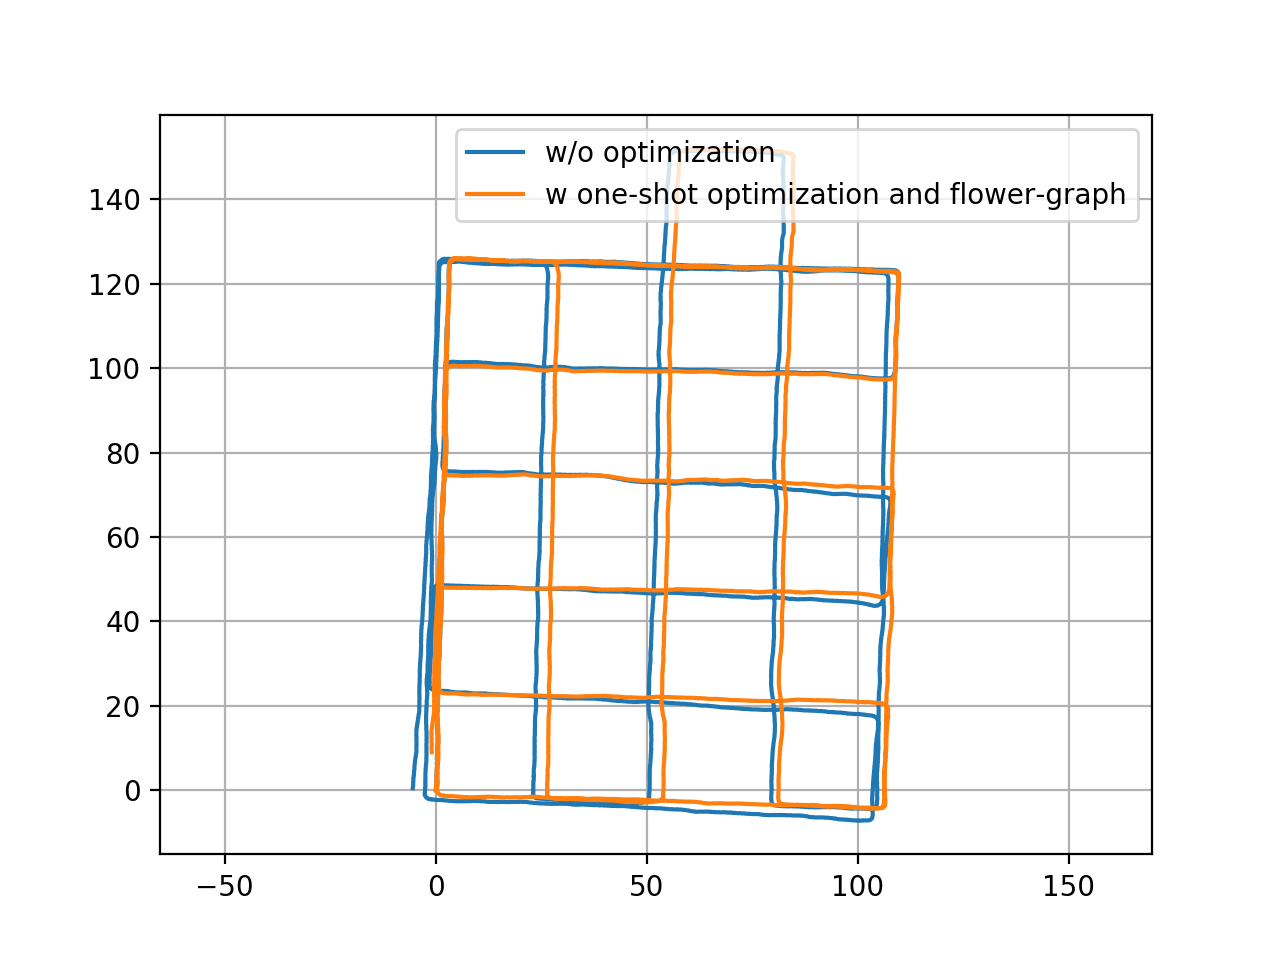

In [55]:
node_poses = np.array(node_poses)
st = 0; stp = -1
plt.figure()
plt.plot(node_poses[st:stp,0], node_poses[st:stp,1], label="w/o optimization" )
plt.plot(oposes[st:stp,0], oposes[st:stp,1], label="w one-shot optimization and flower-graph")
plt.axis('equal')
plt.legend()
plt.grid()

In [56]:
import pickle
with open("./maps/5/oposes_3.pickle",'wb') as f:
    pickle.dump(oposes,f)

### Visualize

### Version-2: Run Optimization iteratively as you find constraints

In [ ]:
temp_poses = copy.deepcopy(node_poses)
dist_th = 10
x_search_window = (-5,5)
y_search_window = (-5,5)
angle_search_window = (-np.pi/6, np.pi/6)
score_th = 0.7
cdist_th = 1.5
constraints = []
use_flower_pg = True
cscores = []
prev_node_dist = 0

for sid in range(0,len(finished_submaps)):
    submap = finished_submaps[sid]
    if submap.iscompressed:
        submap.decompress_data()
    hgrids = bb.compute_hierarchical_grid(submap.grid, num_levels = 4)
    
    for nid in range(0, submap.node_ids[-1]):
        npose = temp_poses[nid]
        spose = temp_poses[submap.node_ids[0]]
        dist = np.linalg.norm(npose[:2] - spose[:2])
        node_dist = abs(node_dists[nid] - node_dists[submap.node_ids[0]])
        if node_dist < 20:
            continue
        if abs(node_dists[nid]-prev_node_dist) < 0.25:
            continue
        prev_node_dist = node_dists[nid]
        if nid not in submap.node_ids and (dist < dist_th):
            print(nid)
            fr_id = insertion_fr_ids[nid]
            ts, frame = lpb.get_frame(fr_id)
            frame = np.copy(frame[:, :6]).astype(np.float64)
            frame = frame[(frame[:,4]>0) & (frame[:,4] < 60)]
            frame = frame[(frame[:,2] > zmin) & (frame[:,2] < zmax)]
            frame_z = voxel_filter(frame[:,:3], voxel_size=0.05)
            if len(frame_z) < 500:
                continue
            #Check all quadrants have points
            if (np.sum((frame_z[:,0] < 0) & (frame_z[:,1] > 0)) <10) or \
            (np.sum((frame_z[:,0] < 0) & (frame_z[:,1] < 0)) <10) or \
            (np.sum((frame_z[:,0] > 0) & (frame_z[:,1] > 0)) <10) or \
            (np.sum((frame_z[:,0] > 0) & (frame_z[:,1] < 0)) <10):
                continue
            frame_z,_ = voxel_filter_fast(frame_z, trunc=False, voxel = 0.25)  
            
            spose_estimate = combine_yelli_poses(get_inverse_yelli_pose(spose), npose)
            hpose, cscore = hierarchical_search(hgrids, spose_estimate, frame_z,
                                        x_search_window,y_search_window,angle_search_window
                                        , max_range = 60, score_th = score_th)

            if hpose is not None: 
                thpose = combine_yelli_poses(spose, hpose)
                mid_pose = temp_poses[submap.node_ids[45]]
                dthpose = thpose[:2] - mid_pose[:2]
                #print(dthpose, spose, mid_pose)
                if np.linalg.norm(dthpose[:2]) > cdist_th:
                    print("Crossed cdist_th .Skipping...",np.linalg.norm(dthpose[:2]))
                    continue
                print("sid, nids, pose, cscore",[submap.node_ids[0], nid], hpose, cscore)
                print("Doing pose graph optimization")
                ps = PoseGraphOptimization()
                for i in range(0,submap.node_ids[-1] + 1 ):
                #for i in range(0,len(temp_poses)):
                    pgpose = temp_poses[i].copy()
    
                    pgpose[2] = normalize_pose(pgpose[2]- np.pi/2)
                    if i == 0:                        
                        ps.add_vertex(i, pgpose, fixed = True)
                    else:
                        ps.add_vertex(i, pgpose)
                    
                #for i in range(0,submap.node_ids[-1] + 1):
                #for i in range(0,nid+1):
                #for i in range(0,len(temp_poses)- 1):
                #    ps.add_edge_from_state([i,i+1], information=np.identity(3))
                for si in range(0, sid+1):
                    si_nid = finished_submaps[si].node_ids[0]
                    for ni in finished_submaps[si].node_ids[1:]:
                        ps.add_edge_from_state([si_nid, ni], information= np.identity(3))
                
                con_pose = hpose.copy()
                con_pose[2] = normalize_pose(con_pose[2] - np.pi/2)
                ps.add_edge([submap.node_ids[0], nid], con_pose, information= np.identity(3))
                ps.optimize()
                
                tpose = temp_poses[submap.node_ids[-1]].copy()
                for ti in range(0, submap.node_ids[-1] + 1):
                #for ti in range(0, len(temp_poses[i])):
                    temp_poses[ti] = ps.get_pose(ti).vector()
                    temp_poses[ti,2] = normalize_pose(temp_poses[ti,2] + np.pi/2)
                
                apose = combine_yelli_poses(temp_poses[submap.node_ids[-1]], get_inverse_yelli_pose(tpose) )
                for ti in range(submap.node_ids[-1]+1, len(temp_poses)):
                    temp_poses[ti] = combine_yelli_poses(apose, temp_poses[ti])
                
                constraints.append(Constraint([submap.node_ids[0], nid], hpose))
                cscores.append(cscore)
  
    print(f"Submap {sid} done..")
    submap.compress_data()

In [94]:
constraints[141].relative_pose

array([-0.08580927,  2.76369964,  1.62889599])

In [93]:
constraints[141].node_ids

[2420, 5641]

In [95]:
constraints[142].node_ids

[2420, 5642]

In [96]:
constraints[145].node_ids

[2420, 5645]

In [99]:
oposes.shape

(9021, 3)

In [101]:
path = r"/Users/anujraaj/ati/data/dataman/maps/map/bosch_16beam_BAU/yelli_poses.npy"
b = np.load(path)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/anujraaj/ati/data/dataman/maps/map/bosch_16beam_BAU/yelli_poses.npy'

In [109]:
type(node_poses)

numpy.ndarray

In [104]:
with open("yelli_poses.npy", "wb") as f:
    np.save(f, oposes)


In [106]:
with open("yelli_poses.npy", "rb") as f:
    blah = np.load(f)

In [116]:
len(oposes)

9021

In [108]:
blah == oposes

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       ...,
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [118]:
64-43

21